# NLP Final Project
## Jorge Alberto Padilla Gutiérrez A01625246
## Adrian Marcelo Suárez Ponce A01197108
## Marcos Leroy Salazar Skinner A01039743
## Jorge Antonio Ruiz Zavalza A01411162
## Guillermo Sáenz González A00823049

This guide follows closely with the [example](https://colab.research.google.com/github/huggingface/blog/blob/master/notebooks/trainer/01_text_classification.ipynb#scrollTo=bwl3I_VGAZXb) from HuggingFace for text classificaion on the GLUE dataset.

Install `multimodal-transformers`, `kaggle`  so we can get the dataset.

In [35]:
!pip install multimodal-transformers
!pip install -q kaggle

## Setting up Kaggle
To get the dataset from kaggle we must upload our kaggle.json file containing our kaggle api token. See https://www.kaggle.com/docs/api for details.

In [36]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (8).json


{'kaggle.json': b'{"username":"jorgepadilla30","key":"fa04db9d1572d435cc1f28ff8a1b9758"}'}

In [37]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists


## All other imports are here:

In [38]:
from dataclasses import dataclass, field
import json
import logging
import os
from typing import Optional

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from transformers import (
    AutoTokenizer,
    AutoConfig,
    Trainer,
    EvalPrediction,
    set_seed
)
from transformers.training_args import TrainingArguments

from multimodal_transformers.data import load_data_from_folder
from multimodal_transformers.model import TabularConfig
from multimodal_transformers.model import AutoModelWithTabular

logging.basicConfig(level=logging.INFO)
os.environ['COMET_MODE'] = 'DISABLED'


## Dataset

Our dataset is the [Womens Clothing E-Commerce Reviews](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews) dataset from kaggle. It contains reviews written by customers about clothing items as well as whether they recommend the data or not. We download the dataset here.

In [39]:
!kaggle datasets download -d snathjr/kindle-books-dataset

kindle-books-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [40]:
!ls

'kaggle (1).json'  'kaggle (5).json'   kaggle.json		  sample_data
'kaggle (2).json'  'kaggle (6).json'   Kindle_Book_Dataset.csv	  test.csv
'kaggle (3).json'  'kaggle (7).json'   kindle-books-dataset.zip   train.csv
'kaggle (4).json'  'kaggle (8).json'   logs			  val.csv


In [41]:
!unzip kindle-books-dataset.zip
!ls

Archive:  kindle-books-dataset.zip
replace Kindle_Book_Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
'kaggle (1).json'  'kaggle (5).json'   kaggle.json		  sample_data
'kaggle (2).json'  'kaggle (6).json'   Kindle_Book_Dataset.csv	  test.csv
'kaggle (3).json'  'kaggle (7).json'   kindle-books-dataset.zip   train.csv
'kaggle (4).json'  'kaggle (8).json'   logs			  val.csv


#### Let us take a look at what the dataset looks like

In [42]:
data_df = pd.read_csv('Kindle_Book_Dataset.csv')
data_df.head(5)

,url,title,author,price,save,pages,description,size,publisher,language,text_to_speech,x_ray,lending,customer_reviews,stars
0,http://www.amazon.com/How-Bartender-Bartending...,How to be a Bartender: Get a Bartending Job Wi...,Dave Allred,9.99,NaN,171.0,"In his revolutionary new book, Dave Allred (Th...",249.0,NaN,English,Enabled,Not Enabled,Enabled,23.0,4.9
1,http://www.amazon.com/Raise-Bar-Action-Based-C...,Raise the Bar: An Action-Based Method for Maxi...,Jon Taffer,2.00,24.00,258.0,If there’s anyone who can prevent a bar or res...,1427.0,Amazon Publishing,English,Enabled,Enabled,Enabled,80.0,4.7
2,http://www.amazon.com/The-Professional-Bartend...,The Professional Bartender's Handbook: A Recip...,Valerie Mellema,9.87,12.08,288.0,The Professional Bartenders Handbook is writte...,5643.0,Atlantic Publishing Group Inc.; illustrated ed...,English,Enabled,Not Enabled,Not Enabled,32.0,4.2
3,http://www.amazon.com/Double-Your-Tips-Jerry-M...,How to Double Your Tips [Kindle Edition],Jerry Minchey,2.99,NaN,36.0,"How to Double Your Tips (For every waitress, w...",98.0,Stony River Media,English,Enabled,Not Enabled,Enabled,6.0,4.5
4,http://www.amazon.com/The-Bartenders-Bible-Mix...,The Bartender's Bible: 1001 Mixed Drinks [Kind...,Gary Regan,5.99,2.00,400.0,Mix Drinks Like A Pro Now you can with this in...,647.0,HarperCollins e-books,English,Enabled,Not Enabled,Not Enabled,59.0,3.6


In [43]:
# Find all the cells with nullish values
#missing_data = data_df.replace(['N/A', 'Unknown', 'Other'], np.nan)
#sns.heatmap(missing_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
data_df = data_df.dropna()

<Figure size 1080x504 with 0 Axes>

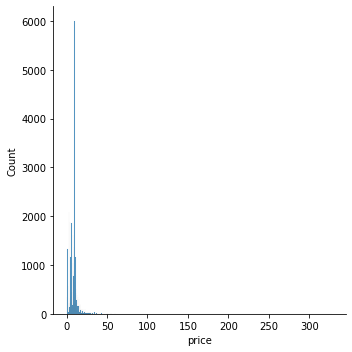

In [44]:
plt.figure(figsize=(15,7))
data_df['price'].nunique()
sns.displot(data_df['price'])

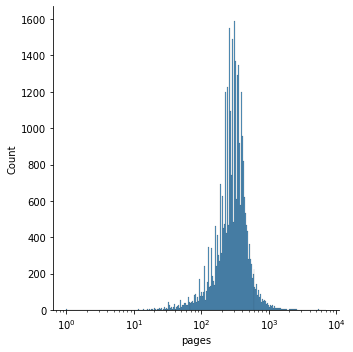

In [45]:
data_df['pages'].nunique()
sns.displot(data_df['pages'], log_scale=True)

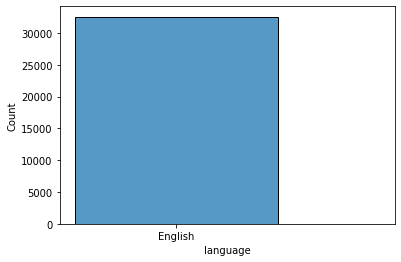

In [46]:
sns.histplot(data=data_df['language'])

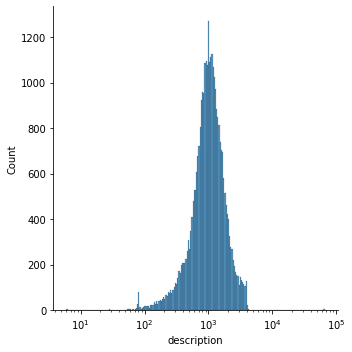

In [47]:
sns.displot(data=data_df['description'].apply(len), log_scale=True)

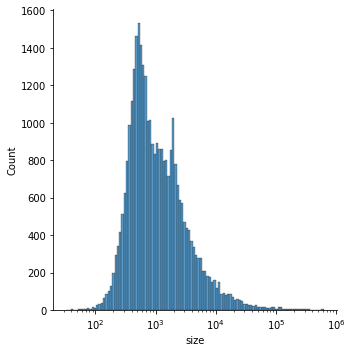

In [48]:
sns.displot(data_df['size'], log_scale=True)

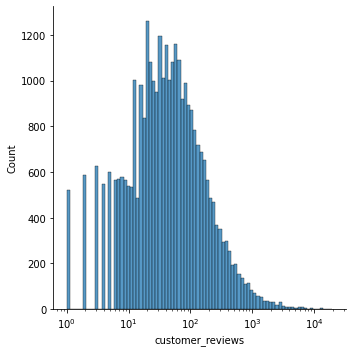

In [49]:
sns.displot(data=data_df['customer_reviews'], log_scale=True)

Value Counts
 4.5    3424
4.4    3108
4.6    3094
4.3    3000
4.2    2818
4.7    2591
4.0    2132
4.1    2071
4.8    2049
3.9    1334
5.0    1328
3.8    1181
4.9     927
3.7     799
3.6     634
3.5     540
3.4     328
3.3     278
3.0     223
3.2     220
3.1     148
2.9      63
2.8      56
2.5      37
2.7      36
2.0      34
2.6      34
2.3      18
1.0      17
2.4      14
2.2      13
2.1       5
1.5       4
1.8       4
1.9       3
1.7       3
1.4       1
1.3       1
1.6       1
Name: stars, dtype: int64


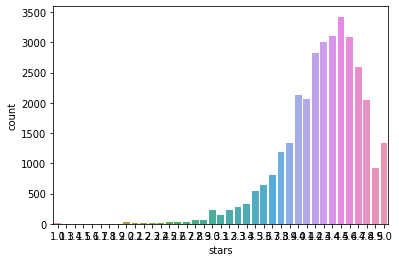

In [50]:
print('Value Counts\n',data_df['stars'].value_counts())
sns.countplot(data=data_df, x='stars')

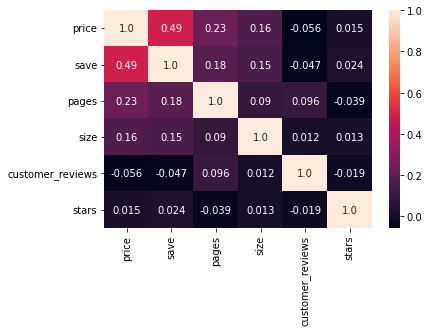

In [51]:
sns.heatmap(data_df.corr(), annot=True, fmt='.2')

We see that the data contains both text in the `Review Text` and `Title` column as well as tabular features in the `Division Name`, `Department Name`, and `Class Name` columns. 

In [52]:
data_df.describe(include=np.object)

,url,title,author,description,publisher,language,text_to_speech,x_ray,lending
count,32571,32571,32571,32571,32571,32571,32571,32571,32571
unique,32571,32275,18852,32358,8443,1,2,2,2
top,http://www.amazon.com/Real-Estate-Investing-Ho...,Twelve Years a Slave [Kindle Edition],James Patterson,More information to be announced soon on this ...,HarperCollins e-books,English,Enabled,Not Enabled,Not Enabled
freq,1,5,71,75,551,32571,29405,20950,19422


In [53]:
data_df.describe()

,price,save,pages,size,customer_reviews,stars
count,32571.000000,32571.000000,32571.000000,32571.000000,32571.000000,32571.000000
mean,9.034280,8.920928,318.268705,2986.024252,116.854687,4.291978
std,8.248698,9.866907,201.921873,14425.807817,373.950367,0.455528
min,0.000000,0.010000,1.000000,33.000000,1.000000,1.000000
25%,4.990000,4.900000,224.000000,490.000000,15.000000,4.000000
50%,8.890000,7.000000,294.000000,865.000000,39.000000,4.400000
75%,9.990000,11.000000,383.000000,2011.000000,99.000000,4.600000
max,328.580000,269.460000,7100.000000,618307.000000,19723.000000,5.000000


Lets only keep the columns that are relevant

In [55]:
data_df = data_df.loc[:1250, ['title', 'description', 'price', 'pages', 'customer_reviews', 'stars']]

In [56]:
data_df.describe(include=np.object)

,title,description
count,1050,1050
unique,1047,1035
top,Think and Grow Rich [Kindle Edition],More information to be announced soon on this ...
freq,2,8


In this demonstration, we split our data into 8:1:1 training splits. We also save our splits to `train.csv`, `val.csv`, and `test.csv` as this is the format our dataloader requires.


In [57]:
train_df, val_df, test_df = np.split(data_df.sample(frac=1), [int(.8*len(data_df)), int(.9 * len(data_df))])
print('Num examples train-val-test')
print(len(train_df), len(val_df), len(test_df))
train_df.to_csv('train.csv')
val_df.to_csv('val.csv')
test_df.to_csv('test.csv')

Num examples train-val-test
840 105 105


## We then define our Experiment Parameters
We use Data Classes to hold each of our arguments for the model, data, and training. 

In [58]:
@dataclass
class ModelArguments:
  """
  Arguments pertaining to which model/config/tokenizer we are going to fine-tune from.
  """

  model_name_or_path: str = field(
      metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"}
  )
  config_name: Optional[str] = field(
      default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
  )
  tokenizer_name: Optional[str] = field(
      default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
  )
  cache_dir: Optional[str] = field(
      default=None, metadata={"help": "Where do you want to store the pretrained models downloaded from s3"}
  )


@dataclass
class MultimodalDataTrainingArguments:
  """
  Arguments pertaining to how we combine tabular features
  Using `HfArgumentParser` we can turn this class
  into argparse arguments to be able to specify them on
  the command line.
  """

  data_path: str = field(metadata={
                            'help': 'the path to the csv file containing the dataset'
                        })
  column_info_path: str = field(
      default=None,
      metadata={
          'help': 'the path to the json file detailing which columns are text, categorical, numerical, and the label'
  })

  column_info: dict = field(
      default=None,
      metadata={
          'help': 'a dict referencing the text, categorical, numerical, and label columns'
                  'its keys are text_cols, num_cols, cat_cols, and label_col'
  })

  categorical_encode_type: str = field(default='ohe',
                                        metadata={
                                            'help': 'sklearn encoder to use for categorical data',
                                            'choices': ['ohe', 'binary', 'label', 'none']
                                        })
  numerical_transformer_method: str = field(default='yeo_johnson',
                                            metadata={
                                                'help': 'sklearn numerical transformer to preprocess numerical data',
                                                'choices': ['yeo_johnson', 'box_cox', 'quantile_normal', 'none']
                                            })
  task: str = field(default="classification",
                    metadata={
                        "help": "The downstream training task",
                        "choices": ["classification", "regression"]
                    })

  mlp_division: int = field(default=4,
                            metadata={
                                'help': 'the ratio of the number of '
                                        'hidden dims in a current layer to the next MLP layer'
                            })
  combine_feat_method: str = field(default='individual_mlps_on_cat_and_numerical_feats_then_concat',
                                    metadata={
                                        'help': 'method to combine categorical and numerical features, '
                                                'see README for all the method'
                                    })
  mlp_dropout: float = field(default=0.1,
                              metadata={
                                'help': 'dropout ratio used for MLP layers'
                              })
  numerical_bn: bool = field(default=True,
                              metadata={
                                  'help': 'whether to use batchnorm on numerical features'
                              })
  use_simple_classifier: str = field(default=True,
                                      metadata={
                                          'help': 'whether to use single layer or MLP as final classifier'
                                      })
  mlp_act: str = field(default='relu',
                        metadata={
                            'help': 'the activation function to use for finetuning layers',
                            'choices': ['relu', 'prelu', 'sigmoid', 'tanh', 'linear']
                        })
  gating_beta: float = field(default=0.2,
                              metadata={
                                  'help': "the beta hyperparameters used for gating tabular data "
                                          "see https://www.aclweb.org/anthology/2020.acl-main.214.pdf"
                              })

  def __post_init__(self):
      assert self.column_info != self.column_info_path
      if self.column_info is None and self.column_info_path:
          with open(self.column_info_path, 'r') as f:
              self.column_info = json.load(f)

### Here are the data and training parameters we will use.
For model we can specify any supported HuggingFace model classes (see README for more details) as well as any AutoModel that are from the supported model classes. For the data specifications, we need to specify a dictionary that specifies which columns are the `text` columns, `numerical feature` columns, `categorical feature` column, and the `label` column. If we are doing classification, we can also specify what each of the labels means in the label column through the `label list`. We can also specifiy these columns using a path to a json file with the argument `column_info_path` to `MultimodalDataTrainingArguments`.

In [59]:
# Columns: ['title', 'description', 'price', 'pages', 'customer_reviews', 'stars']
text_cols = ['title', 'description']
#cat_cols = ['Clothing ID', 'Division Name', 'Department Name', 'Class Name'] #No tenemos cols categoricas
numerical_cols = ['pages', 'price']

column_info_dict = {
    'text_cols': text_cols,
    'num_cols': numerical_cols,
    'cat_cols': [],
    'label_col': 'stars',
    'label_list': []
}


model_args = ModelArguments(
    model_name_or_path='bert-base-uncased'
)

data_args = MultimodalDataTrainingArguments(
    data_path='.',
    combine_feat_method='gating_on_cat_and_num_feats_then_sum',
    column_info=column_info_dict,
    task='regression'
)

training_args = TrainingArguments(
    output_dir="./logs/model_name",
    logging_dir="./logs/runs",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=4,
    num_train_epochs=1,
    evaluate_during_training=True,
    logging_steps=12,
    eval_steps=250,
    
)

set_seed(training_args.seed)



```
# Tiene formato de código
```

## Now we can load our model and data. 
### We first instantiate our HuggingFace tokenizer
This is needed to prepare our custom torch dataset. See `torch_dataset.py` for details.

In [60]:
tokenizer_path_or_name = model_args.tokenizer_name if model_args.tokenizer_name else model_args.model_name_or_path
print('Specified tokenizer: ', tokenizer_path_or_name)
tokenizer = AutoTokenizer.from_pretrained(
    tokenizer_path_or_name,
    cache_dir=model_args.cache_dir,
)

Specified tokenizer:  bert-base-uncased


### Load dataset csvs to torch datasets
The function `load_data_from_folder` expects a path to a folder that contains `train.csv`, `test.csv`, and/or `val.csv` containing the respective split datasets. 

In [61]:
# Get Datasets
train_dataset, val_dataset, test_dataset = load_data_from_folder(
    data_args.data_path,
    data_args.column_info['text_cols'],
    tokenizer,
    label_col=data_args.column_info['label_col'],
    label_list=data_args.column_info['label_list'],
    categorical_cols=data_args.column_info['cat_cols'],
    numerical_cols=data_args.column_info['num_cols'],
    sep_text_token_str=tokenizer.sep_token,
)

INFO:multimodal_transformers.data.data_utils:2 numerical columns
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2593: UserWarning: n_quantiles (1000) is greater than the total number of samples (840). n_quantiles is set to n_samples.
  "n_samples." % (self.n_quantiles, n_samples)
INFO:multimodal_transformers.data.data_utils:0 categorical columns
INFO:multimodal_transformers.data.data_utils:2 numerical columns
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [62]:
num_labels = len(np.unique(train_dataset.labels))
num_labels

29

In [63]:
config = AutoConfig.from_pretrained(
        model_args.config_name if model_args.config_name else model_args.model_name_or_path,
        cache_dir=model_args.cache_dir,
    )
tabular_config = TabularConfig(num_labels=num_labels,
                               numerical_feat_dim=train_dataset.numerical_feats.shape[1],
                               **vars(data_args))
config.tabular_config = tabular_config

In [64]:
model = AutoModelWithTabular.from_pretrained(
        model_args.config_name if model_args.config_name else model_args.model_name_or_path,
        config=config,
        cache_dir=model_args.cache_dir
    )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertWithTabular: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertWithTabular from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertWithTabular from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertWithTabular were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifi

### We need to define a task-specific way of computing relevant metrics:

In [65]:
import numpy as np
from scipy.special import softmax
from sklearn.metrics import (
    # auc,
    # precision_recall_curve,
    # roc_auc_score,
    # f1_score,
    # confusion_matrix,
    # matthews_corrcoef,
    mean_absolute_error,
    mean_squared_error,
    r2_score,

)

def calc_classification_metrics(p: EvalPrediction):
  pred_labels = np.argmax(p.predictions, axis=1)
  pred_scores = softmax(p.predictions, axis=1)[:, 1]
  labels = p.label_ids

  return {
    'mean_absolute_error': mean_absolute_error(labels, pred_labels),
    'neg_mean_squared_error': mean_squared_error(labels, pred_labels),
    'r2': r2_score(labels, pred_labels),
  }

In [66]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=calc_classification_metrics,
)

## Launching the training is as simple is doing trainer.train() 🤗

In [67]:
#%%time
trainer.train()

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/210 [00:00<?, ?it/s]

{'loss': 2.327721913655599, 'learning_rate': 4.714285714285714e-05, 'epoch': 0.05714285714285714, 'step': 12}
{'loss': 1.390536626180013, 'learning_rate': 4.428571428571428e-05, 'epoch': 0.11428571428571428, 'step': 24}
{'loss': 0.5521310170491537, 'learning_rate': 4.1428571428571437e-05, 'epoch': 0.17142857142857143, 'step': 36}
{'loss': 0.5578835805257162, 'learning_rate': 3.857142857142858e-05, 'epoch': 0.22857142857142856, 'step': 48}
{'loss': 0.8355585734049479, 'learning_rate': 3.571428571428572e-05, 'epoch': 0.2857142857142857, 'step': 60}
{'loss': 0.8436864217122396, 'learning_rate': 3.285714285714286e-05, 'epoch': 0.34285714285714286, 'step': 72}
{'loss': 0.623992919921875, 'learning_rate': 3e-05, 'epoch': 0.4, 'step': 84}
{'loss': 0.6767088572184244, 'learning_rate': 2.714285714285714e-05, 'epoch': 0.45714285714285713, 'step': 96}
{'loss': 0.52593994140625, 'learning_rate': 2.4285714285714288e-05, 'epoch': 0.5142857142857142, 'step': 108}
{'loss': 0.8302103678385416, 'learnin

TrainOutput(global_step=210, training_loss=0.8427054268973214)

### Check that our training was successful using TensorBoard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ./logs/runs --port=6006

## Interface




In [74]:
pip install streamlit

     |████████████████████████████████| 9.1 MB 4.5 MB/s 
     |████████████████████████████████| 4.3 MB 30.0 MB/s 
     |████████████████████████████████| 178 kB 54.5 MB/s 
     |████████████████████████████████| 111 kB 63.5 MB/s 
     |████████████████████████████████| 76 kB 5.4 MB/s 
     |████████████████████████████████| 180 kB 69.3 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 125 kB 58.0 MB/s 
     |████████████████████████████████| 791 kB 58.3 MB/s 
     |████████████████████████████████| 374 kB 52.9 MB/s 
  Created wheel for pympler: filename=Pympler-0.9-py3-none-any.whl size=164824 sha256=170ef462ddd132f36692363f4336820fafea47d4f95a1afba479203fc1d4704e
  Stored in directory: /root/.cache/pip/wheels/1a/f3/d8/35d5614ea4ddd295ffb9372a5f2f9570d9593d1ea4be33ec6d
  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13478 sha256=426bc29b7b460672102a71f1860ed3e0dadbcaf9e52809ed28214c349511ff32
  Stored in direc

In [75]:
pip install pyngrok==4.1.10

  Created wheel for pyngrok: filename=pyngrok-4.1.10-py3-none-any.whl size=16391 sha256=e2057dc3b062f3a442a21571d9b1b6dd47cfd89865e4f36b231fefa95344d9b7
  Stored in directory: /root/.cache/pip/wheels/75/b5/e3/4f43c6750284bce1d9c6f07aed78437f805d32dfe55503d1a0
Successfully built pyngrok


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jorgezavalza","key":"2ee48bd0cd1b0ca83b44e8b18c397b8a"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d snathjr/kindle-books-dataset

 46% 12.0M/26.1M [00:00<00:00, 125MB/s]
100% 26.1M/26.1M [00:00<00:00, 128MB/s]


In [ ]:
!ls

kaggle.json  kindle-books-dataset.zip  sample_data


In [ ]:
!unzip kindle-books-dataset.zip
!ls

Archive:  kindle-books-dataset.zip
  inflating: Kindle_Book_Dataset.csv  
kaggle.json  Kindle_Book_Dataset.csv  kindle-books-dataset.zip	sample_data


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data_df = pd.read_csv('Kindle_Book_Dataset.csv')
data_df.describe(include=np.object)
data_df = data_df.loc[:, ['title', 'description', 'price', 'pages', 'customer_reviews', 'stars']]
data_df = data_df.dropna()
data_df

,title,description,price,pages,customer_reviews,stars
0,How to be a Bartender: Get a Bartending Job Wi...,"In his revolutionary new book, Dave Allred (Th...",9.99,171.0,23.0,4.9
1,Raise the Bar: An Action-Based Method for Maxi...,If there’s anyone who can prevent a bar or res...,2.00,258.0,80.0,4.7
2,The Professional Bartender's Handbook: A Recip...,The Professional Bartenders Handbook is writte...,9.87,288.0,32.0,4.2
3,How to Double Your Tips [Kindle Edition],"How to Double Your Tips (For every waitress, w...",2.99,36.0,6.0,4.5
4,The Bartender's Bible: 1001 Mixed Drinks [Kind...,Mix Drinks Like A Pro Now you can with this in...,5.99,400.0,59.0,3.6
...,...,...,...,...,...,...
49192,"Famous Gamblers, Poker History, and Texas Stor...","You have a great writing style, very credible,...",6.99,256.0,14.0,4.3
49193,The Madness of March: Bonding and Betting with...,"Every spring, the first four days of the NCAA ...",9.99,243.0,8.0,3.8
49194,The Football Betting Bible [Kindle Edition],The vast majority of sports bettors are guaran...,6.50,70.0,2.0,4.0
49195,Winning on Betfair For Dummies [Kindle Edition],Betfair is the world’s leading online betting ...,10.49,210.0,NaN,NaN


In [ ]:
train_df, val_df, test_df = np.split(data_df.sample(frac=1), [int(.8*len(data_df)), int(.9 * len(data_df))])
train_df = train_df.sample(frac=0.3, replace=True)
val_df = val_df.sample(frac=0.3, replace=True)
test_df = test_df.sample(frac=0.3, replace=True)
print('Num examples train-val-test')
print(len(train_df), len(val_df), len(test_df))
train_df.to_csv('train.csv')
val_df.to_csv('val.csv')
test_df.to_csv('test.csv')



Num examples train-val-test
11807 1476 1476


In [69]:
predictions = trainer.predict(test_dataset)

Prediction:   0%|          | 0/14 [00:00<?, ?it/s]

In [70]:
pred_df = pd.DataFrame(predictions[1])
pred_df.to_csv('pred.csv')

In [83]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas_gbq
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

data = pd.read_csv('test.csv')
pred = pd.read_csv('pred.csv')

header = st.container()
dataset = st.container()
features = st.container()
modelTraining = st.container()
prediction = st.container()

with header:
	st.title("Welcome to our books dataset")
 
with dataset:
	st.header("Data")
	st.write(data.head(20))
 
	st.subheader('Customer reviews')
	customer_rev = pd.DataFrame(data['customer_reviews'].value_counts()).head(50)
	st.bar_chart(customer_rev)
 
	st.subheader('Pages')
	pages_g = pd.DataFrame(data['pages'].value_counts()).head(50)
	st.bar_chart(pages_g)
 
	st.subheader('Price')
	price_g = pd.DataFrame(data['price'].value_counts()).head(50)
	st.bar_chart(price_g)
 
	st.subheader('Stars')
	stars_g = pd.DataFrame(data['stars'].value_counts()).head(50)
	st.bar_chart(stars_g)

with features:
	st.header("Features")
 
	st.markdown('* **Recomendations**: Here you can put any kind of information')
	st.markdown('* **Interviews**: Here you can put any kind of inofmration')
 

# with modelTraining:
# 	st.header("Training Model")
# 	st.text('Here you can choose hyperparameters of the model and see how the performance changes')
 
# 	sel_col, disp_col = st.columns(2)
# 	max_depth = sel_col.slider('What should be the max depth of the model?', min_value=10, max_value=100, value=0, step=1)
 
# 	n_estimators = sel_col.selectbox('How many book should there be?', options=[100,200,300,'No limit'])
	
# 	sel_col.text('Here is a list of features')
# 	sel_col.write(data.columns)
 
with prediction:
	st.header("Prediction with Model")
	st.text('Here you can use the trained model to evaluate the accuracy')

	sel_col, disp_col = st.columns(2)
	input_number = sel_col.slider('Which book do you want to predict?(as a number in our set)', min_value=0, max_value=100, value=0, step=1)
	# input_feature = sel_col.text_input('Which feature should be used as the input feature?')
	st.text(pred.iloc[input_number,1])
 

 
	
	
	
	
	# input_feature = sel_col.text_input('Which feature should be used as the input feature?')

#	if n_estimators == 'No limit':
#		regr = RandomForestRegressor(max_depth=max_depth)
#	else:
#		regr = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators)
#

#	X = data[[input_feature]]    
#	y = data[['customer_reviews']]

#	regr.fit(X, y) 
#	prediction = regr.predict(y)

#	disp_col.subheader('Mean absolute error:') 
#	disp_col.write(mean_absolute_error(y, prediction))


Overwriting app.py


In [72]:
!ls

 app.py		   'kaggle (5).json'   Kindle_Book_Dataset.csv	  test.csv
'kaggle (1).json'  'kaggle (6).json'   kindle-books-dataset.zip   train.csv
'kaggle (2).json'  'kaggle (7).json'   logs			  val.csv
'kaggle (3).json'  'kaggle (8).json'   pred.csv
'kaggle (4).json'   kaggle.json        sample_data


Se modifica el token por usuario

In [76]:
!ngrok authtoken 21ZhSLeNerV4lvIDihRlxvjcYEe_2vphQzEM6EWBvPf2q6o6o

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [77]:
from pyngrok import ngrok

In [78]:
!streamlit run app.py &>/dev/null&

In [79]:
!pgrep streamlit

1848


In [80]:
public_url = ngrok.connect(port='8501')

INFO:pyngrok.process:ngrok process starting: 1854
INFO:pyngrok.process:t=2021-11-29T05:33:47+0000 lvl=info msg="no configuration paths supplied"

INFO:pyngrok.process:t=2021-11-29T05:33:47+0000 lvl=info msg="using configuration at default config path" path=/root/.ngrok2/ngrok.yml

INFO:pyngrok.process:t=2021-11-29T05:33:47+0000 lvl=info msg="open config file" path=/root/.ngrok2/ngrok.yml err=nil

INFO:pyngrok.process:t=2021-11-29T05:33:47+0000 lvl=info msg="starting web service" obj=web addr=127.0.0.1:4040

INFO:pyngrok.process:t=2021-11-29T05:33:47+0000 lvl=info msg="tunnel session started" obj=tunnels.session

INFO:pyngrok.process:t=2021-11-29T05:33:47+0000 lvl=info msg="client session established" obj=csess id=7e8f6152039b

INFO:pyngrok.process:ngrok process has started: http://127.0.0.1:4040
INFO:pyngrok.process:t=2021-11-29T05:33:47+0000 lvl=info msg=start pg=/api/tunnels id=69f5b79939c9b913

INFO:pyngrok.process:t=2021-11-29T05:33:47+0000 lvl=info msg=end pg=/api/tunnels id=69f5b

In [81]:
public_url

'http://9444-34-70-88-208.ngrok.io'